(getting-started)=
# Getting Started

This notebook gets you started with a brief nDCG evaluation with LensKit for Python.

This notebook is also available on [Google Collaboratory](https://colab.research.google.com/drive/1ym040cKkQf85epu80VtIkMXy3LpfYQky?usp=sharing) and [nbviewer](https://nbviewer.jupyter.org/github/lenskit/lkpy/blob/master/doc/GettingStarted.ipynb).

## Setup

We first import the LensKit components we need:

In [1]:
from lenskit.als import BiasedMFScorer
from lenskit.batch import recommend
from lenskit.data import ItemListCollection, UserIDKey, load_movielens
from lenskit.knn import ItemKNNScorer
from lenskit.metrics import NDCG, RBP, RecipRank, RunAnalysis
from lenskit.pipeline import topn_pipeline
from lenskit.splitting import SampleFrac, crossfold_users

And Pandas is very useful, as is Seaborn for plotting:

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

The `pyprojroot` package makes it easy to find input data:

In [3]:
from pyprojroot.here import here

## Loading Data

We're going to use the ML-100K data set:

In [4]:
ml100k = load_movielens(here("data/ml-100k.zip"))
ml100k.interaction_table(format="pandas", original_ids=True).head()

user_id  item_id  rating  timestamp
0        1        1     5.0  874965758
1        1        2     3.0  876893171
2        1        3     4.0  878542960
3        1        4     3.0  876893119
4        1        5     3.0  889751712

## Defining Recommenders

Let's set up two scoring models:

In [5]:
model_ii = ItemKNNScorer(k=20)
model_als = BiasedMFScorer(features=50)

For each of these, we also need to make a :ref:`pipeline <pipeline>`:

In [6]:
pipe_ii = topn_pipeline(model_ii)
pipe_als = topn_pipeline(model_als)

## Running the Evaluation

In LensKit, our evaluation proceeds in 2 steps:

1. Generate recommendations
2. Measure them

If memory is a concern, we can measure while generating, but we will not do that for now.

Let's start by creating and collecting the recommendations; we will generate 100 recommendations per user, and will collect all of them into a single {py:class}`~lenskit.data.ItemListCollection`:

In [7]:
# test data is organized by user
all_test = ItemListCollection(UserIDKey)
# recommendations will be organized by model and user ID
all_recs = ItemListCollection(["model", "user_id"])

for split in crossfold_users(ml100k, 5, SampleFrac(0.2)):
    # collect the test data
    all_test.add_from(split.test)

    # train the pipeline, cloning first so a fresh pipeline for each split
    fit_als = pipe_als.clone()
    fit_als.train(split.train)
    # generate recs
    als_recs = recommend(fit_als, split.test.keys(), 100)
    all_recs.add_from(als_recs, model="ALS")

    # do the same for item-item
    fit_ii = pipe_ii.clone()
    fit_ii.train(split.train)
    ii_recs = recommend(fit_ii, split.test.keys(), 100)
    all_recs.add_from(ii_recs, model="II")

/Users/mde48/LensKit/lkpy/lenskit/lenskit/als/_explicit.py:59: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1733624403138/work/aten/src/ATen/SparseCsrTensorImpl.cpp:55.)
  rmat = rmat.to_sparse_csr()


## Measuring Recommendations

We analyze our recommendation lists with a {py:class}`~lenskit.metrics.RunAnalysis` and some metrics.

In [ ]:
ran = RunAnalysis()
ran.add_metric(NDCG())
ran.add_metric(RBP())
ran.add_metric(RecipRank())
results = ran.measure(all_recs, all_test)

Now we have nDCG values, along with some other metrics! We can start computing and plotting.

In [9]:
results.list_metrics().groupby("model").mean()

NDCG       RBP  RecipRank
model                               
ALS    0.125894  0.088839    0.19244
II     0.095334  0.036945    0.10837

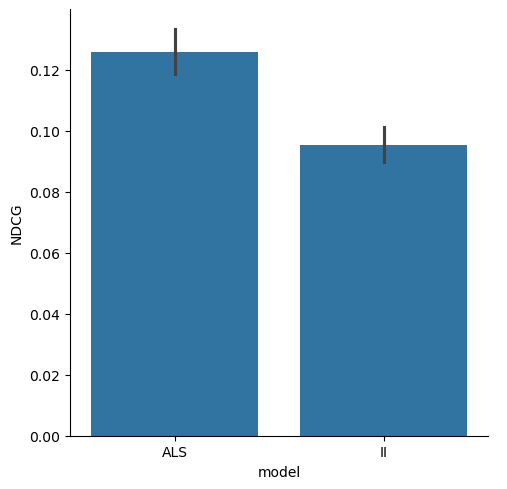

In [10]:
sns.catplot(results.list_metrics().reset_index(), x="model", y="NDCG", kind="bar")
plt.show()